# Escargo Traffic Light Classifier

### Training new classifier based on SqueezeNet approach 
https://github.com/DeepScale/SqueezeNet

In [1]:
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
import glob
import os
import random
from random import randint
import math
import numpy as np
import keras
from keras import backend as K
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras.models import load_model
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout, Input, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, Activation, Lambda, concatenate, ELU
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

Using TensorFlow backend.


### load dataset, only consider traffic light colors

In [2]:
image_types = ["red", "green", "yellow"]
input_img_x = 32
input_img_y = 32

full_set = []
for im_type in image_types:
    for ex in glob.glob(os.path.join("carla/", im_type, "*")):
        im = cv2.imread(ex)
        if not im is None:
            # Resize image to defined height and width
            im = cv2.resize(im, (input_img_x, input_img_y))
            # Convert to RGB...cv2 import is BGR
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) 
            # One hot encode the classes
            one_hot_array = [0] * len(image_types)
            one_hot_array[image_types.index(im_type)] = 1
            # Check shape
            assert(im.shape == (input_img_x, input_img_y, 3))
            full_set.append((im, one_hot_array, ex))

# Shuffle the data
random.shuffle(full_set)
print("Loaded train images, overall amount of images: {}".format(len(full_set)))

Loaded train images, overall amount of images: 480


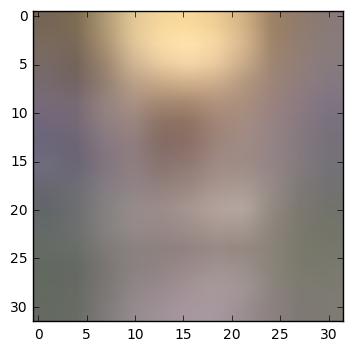

In [3]:
plt.imshow(full_set[0][0])

In [4]:
# Define split and batch size
train_test_split_ratio = 0.9
batch_size = 32

# Split data into a training and test 
split_index = int(math.floor(len(full_set) * train_test_split_ratio))
train_set = full_set[:split_index]
test_set = full_set[split_index:]

# Ensure data length can be divided by batch size
train_set_offset = len(train_set) % batch_size
test_set_offset = len(test_set) % batch_size
# Cut off offset
train_set = train_set[: len(train_set) - train_set_offset]
test_set = test_set[: len(test_set) - test_set_offset]
# Split
train_x, train_y, train_z = zip(*train_set)
test_x, test_y, test_z = zip(*test_set)
# Convert to numpy array
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)
print("Training samples: {}".format(len(train_y)))
print("Test samples: {}".format(len(test_y)))

Training samples: 416
Test samples: 32


Example image:


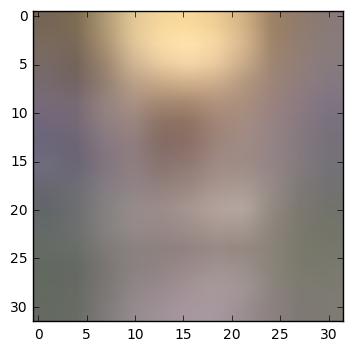

In [5]:
print("Example image:")
plt.imshow(train_x[0])

In [6]:
def get_class_weights(y):
    unique, counts = np.unique(y, return_counts=True)
    majority = max(counts)
    return  {cls: float(majority/count) for cls, count in zip(unique, counts)}

train_y_dec = np.argmax(train_y, axis=1)
class_weights = get_class_weights(train_y_dec)
print(class_weights)

{0: 1.4489795918367347, 1: 1.0, 2: 3.8035714285714284}


### Implementation of SqueezeNet

In [7]:
drop_rate = 0.3

In [8]:
def fire_module(x, fire_id, squeeze=16, expand=64): 
    # Squeeze part with 1x1 conv
    x = Conv2D(squeeze, (1, 1), padding='valid', name='fire' + str(fire_id) + '/' + "squeeze1x1")(x)
    x = Activation('elu', name='fire' + str(fire_id) + '/elu_squeeze1x1')(x)
    # Expand part with 1x1 conv
    left = Conv2D(expand, (1, 1), padding='valid', name='fire' + str(fire_id) + '/' + "expand1x1")(x)
    left = Activation('elu', name='fire' + str(fire_id) + '/elu_expand1x1')(left)
    # Expand part with 3x3 conv
    right = Conv2D(expand, (3, 3), padding='same', name='fire' + str(fire_id) + '/' + "expand3x3")(x)
    right = Activation('elu', name='fire' + str(fire_id) + '/elu_expand3x3')(right)
    # Fuse left and right expansion together
    x = concatenate([left, right], axis=3, name='fire' + str(fire_id) + '/' + 'concat')
    return x

def squeeze_model():

    input_img = Input(shape=(32, 32, 3))
    
    # Normalization from 0 to 1
    x = Lambda(lambda x: x/255.0, input_shape=(32, 32, 3))(input_img)
    
    # Use two fire modules with 16 filter squeeze and 64 filter expand
    x = fire_module(x, fire_id=1, squeeze=16, expand=64)
    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    
    # Use two fire modules with 32 filter squeeze and 128 filter expand
    x = fire_module(x, fire_id=3, squeeze=32, expand=128)
    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    
    # Use two fire modules with 48 filter squeeze and 192 filter expand
    x = fire_module(x, fire_id=5, squeeze=48, expand=192)
    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    
    # Dropout with drop rate
    x = Dropout(drop_rate)(x)  
    
    # Last conv layer
    x = Conv2D(100, (1, 1), padding='valid')(x)
    x = Activation('elu')(x)
    
    # Global average pooling
    x = GlobalAveragePooling2D()(x)
    
    # Output layer for the three classes with softmax
    out = Dense(3, name='loss', activation="softmax")(x)
    
    # Build model
    model = Model(inputs=input_img, outputs=[out])     
    return model

# Summarize the model
model = squeeze_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
fire1/squeeze1x1 (Conv2D)       (None, 32, 32, 16)   64          lambda_1[0][0]                   
__________________________________________________________________________________________________
fire1/elu_squeeze1x1 (Activatio (None, 32, 32, 16)   0           fire1/squeeze1x1[0][0]           
__________________________________________________________________________________________________
fire1/expa

In [9]:
epochs = 35

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

# Callbacks for checkpoints, visualisation and early stop
check_point = ModelCheckpoint('./checkpoints/model-e{epoch:03d}.h5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto')
# Early stop helps to prevent overfitting by stopping the training early in case that there is no chance anymore
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='min')
        
history = model.fit(x=train_x,y=train_y,verbose=2,batch_size=batch_size,epochs=epochs,
                    validation_data = (test_x, test_y), callbacks=[early_stop, check_point])

model.save_weights('./model/model_carla.h5')
print("...Done! Model trained!")

Train on 416 samples, validate on 32 samples
Epoch 1/35
 - 5s - loss: 1.0095 - acc: 0.4904 - val_loss: 1.1450 - val_acc: 0.3750
Epoch 2/35
 - 4s - loss: 0.9563 - acc: 0.5120 - val_loss: 1.0969 - val_acc: 0.3750
Epoch 3/35
 - 4s - loss: 0.9172 - acc: 0.5264 - val_loss: 1.0821 - val_acc: 0.3750
Epoch 4/35
 - 4s - loss: 0.8171 - acc: 0.6683 - val_loss: 0.8100 - val_acc: 0.6562
Epoch 5/35
 - 4s - loss: 0.5890 - acc: 0.7644 - val_loss: 0.7190 - val_acc: 0.6562
Epoch 6/35
 - 4s - loss: 0.4786 - acc: 0.8077 - val_loss: 0.5931 - val_acc: 0.6875
Epoch 7/35
 - 4s - loss: 0.4202 - acc: 0.8173 - val_loss: 0.4424 - val_acc: 0.8750
Epoch 8/35
 - 4s - loss: 0.3215 - acc: 0.8630 - val_loss: 0.3986 - val_acc: 0.8750
Epoch 9/35
 - 4s - loss: 0.2894 - acc: 0.8846 - val_loss: 0.3981 - val_acc: 0.7812
Epoch 10/35
 - 4s - loss: 0.2617 - acc: 0.9111 - val_loss: 0.3673 - val_acc: 0.8438
Epoch 11/35
 - 4s - loss: 0.2402 - acc: 0.9135 - val_loss: 0.3415 - val_acc: 0.8750
Epoch 12/35
 - 4s - loss: 0.2303 - acc: 

### Visualize accuracies andlosses

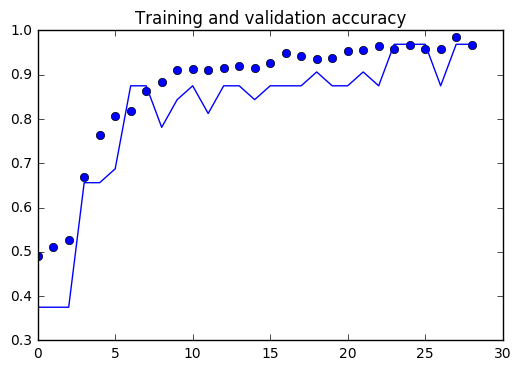

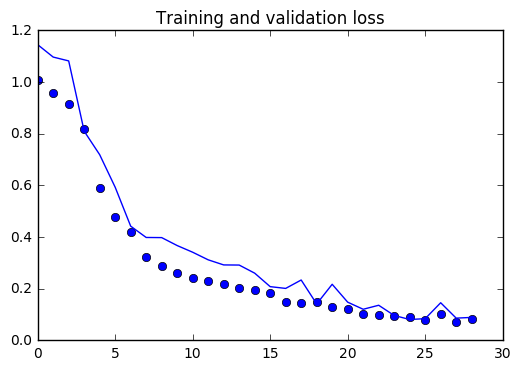

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.show()

### Load the saved weights into a new model with same architecture

In [11]:
K.set_learning_phase(0)
model2 = squeeze_model()
model2.load_weights("./model/model_carla.h5")
print("New SqueezeNet model with saved weights loaded!")

New SqueezeNet model with saved weights loaded!


Predicted traffic light color: red
Original traffic light color: yellow


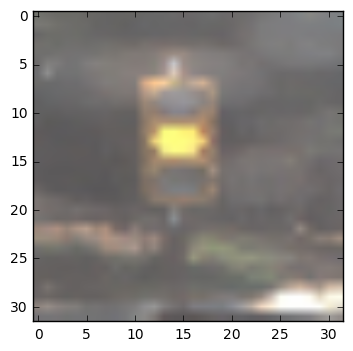

In [12]:
def predict(image):
    pred_ = list(model2.predict(image, verbose=0)[0])
    pred_idx = pred_.index(max(pred_))
    predicted_label = image_types[pred_idx]
    return predicted_label

idx_ = randint(0, len(test_x))
image = test_x[idx_]
plt.imshow(image)
img = np.reshape(image, (1, 32, 32, 3))
print("Predicted traffic light color: {}".format(predict(img)))
print("Original traffic light color: {}".format(image_types[np.argmax(test_y[idx_])]))


In [13]:
input_img_x = 32
input_img_y = 32

test_set = []

for ex in glob.glob(os.path.join("./test_images_carla", "*")):
    im = cv2.imread(ex)
    if not im is None:
        im = cv2.resize(im, (input_img_x, input_img_y))
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) 
        test_set.append(im)

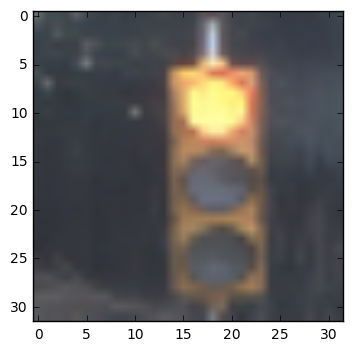

Prediction: red


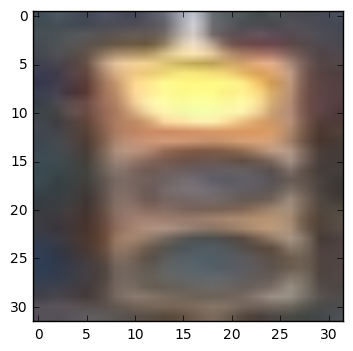

Prediction: red


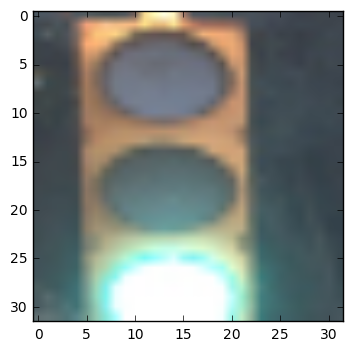

Prediction: green


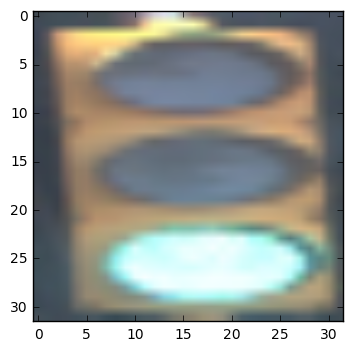

Prediction: green


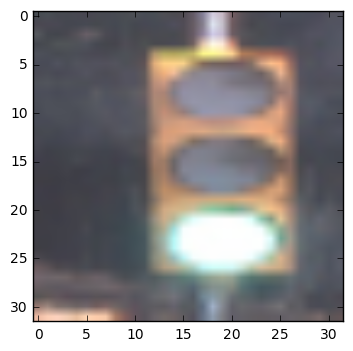

Prediction: green


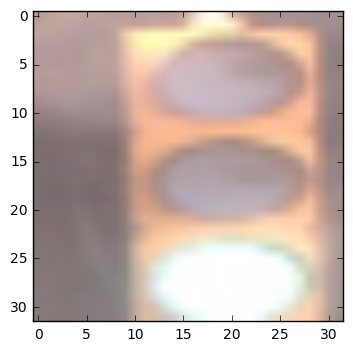

Prediction: green


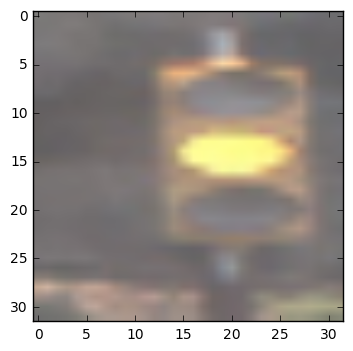

Prediction: yellow


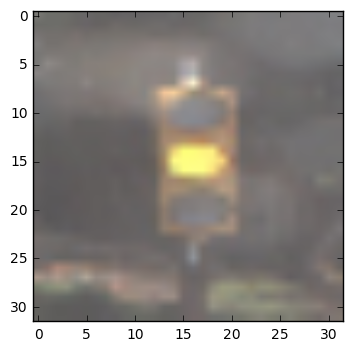

Prediction: yellow


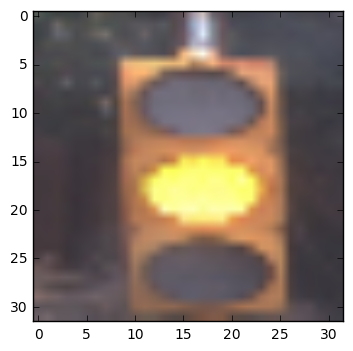

Prediction: yellow


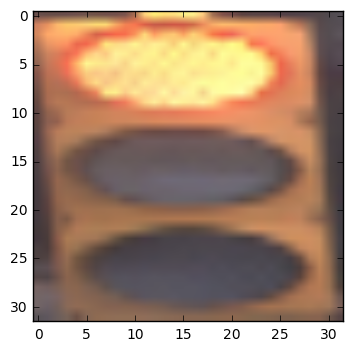

Prediction: red


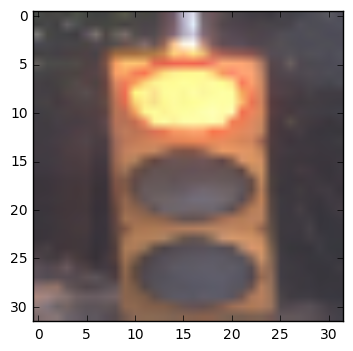

Prediction: red


In [14]:
for img in test_set:
    plt.imshow(img)
    plt.show()
    img = np.reshape(img, (1, 32, 32, 3))
    pred = predict(img)
    print("Prediction: {}".format(pred))

### Convert the saved keras model with weights into a tensorflow model

In [15]:
pred = [None]
pred_node_names = [None]
pred_node_names[0] = 'output_'+str(0)
pred[0] = tf.identity(model.output[0], name=pred_node_names[0])
sess = K.get_session()
constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)
# Output the model as Tensorflow graph
graph_io.write_graph(constant_graph, 'model', 'model_classification_carla_tf130.pb', as_text=False)
print('Keras model converted to TensorFlow model!')

INFO:tensorflow:Froze 40 variables.
Converted 40 variables to const ops.
Keras model converted to TensorFlow model!


In [16]:
# Function to load a graph from a protobuf file
def load_graph(graph_file):
    with tf.Session(graph=tf.Graph(), config=config) as sess:
        gd = tf.GraphDef()
        with tf.gfile.Open(graph_file, 'rb') as f:
            data = f.read()
            gd.ParseFromString(data)
        tf.import_graph_def(gd, name='')
        return sess.graph

# Optimizations for Tensorflow (from tutorial)
config = tf.ConfigProto()
jit_level = tf.OptimizerOptions.ON_1
config.graph_options.optimizer_options.global_jit_level = jit_level    

# Load graph
graph = load_graph(os.path.join('model', 'model_classification_carla.pb'))

In [17]:
graph.get_operations()

[<tf.Operation 'input_1' type=Placeholder>,
 <tf.Operation 'lambda_1/truediv/y' type=Const>,
 <tf.Operation 'lambda_1/truediv' type=RealDiv>,
 <tf.Operation 'fire1/squeeze1x1/kernel' type=Const>,
 <tf.Operation 'fire1/squeeze1x1/kernel/read' type=Identity>,
 <tf.Operation 'fire1/squeeze1x1/bias' type=Const>,
 <tf.Operation 'fire1/squeeze1x1/bias/read' type=Identity>,
 <tf.Operation 'fire1/squeeze1x1/convolution' type=Conv2D>,
 <tf.Operation 'fire1/squeeze1x1/BiasAdd' type=BiasAdd>,
 <tf.Operation 'fire1/elu_squeeze1x1/Elu' type=Elu>,
 <tf.Operation 'fire1/expand1x1/kernel' type=Const>,
 <tf.Operation 'fire1/expand1x1/kernel/read' type=Identity>,
 <tf.Operation 'fire1/expand1x1/bias' type=Const>,
 <tf.Operation 'fire1/expand1x1/bias/read' type=Identity>,
 <tf.Operation 'fire1/expand1x1/convolution' type=Conv2D>,
 <tf.Operation 'fire1/expand1x1/BiasAdd' type=BiasAdd>,
 <tf.Operation 'fire1/elu_expand1x1/Elu' type=Elu>,
 <tf.Operation 'fire1/expand3x3/kernel' type=Const>,
 <tf.Operation '

In [18]:
# Get input and output tensors
in_graph = graph.get_tensor_by_name('input_1:0')
out_graph = graph.get_tensor_by_name('output_0:0')

yellow


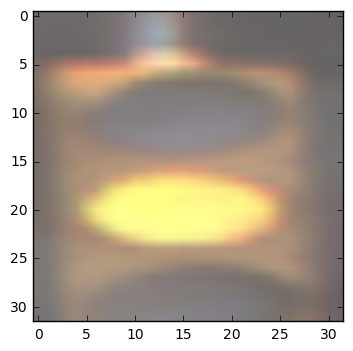

In [ ]:
# Pick a random image from the test set
image = test_x[randint(0, len(test_x))]
plt.imshow(image)

# Do the prediction here
with tf.Session(graph=graph, config=config) as sess:   
    sfmax = list(sess.run(tf.nn.softmax(out_graph.eval(feed_dict={in_graph: [image]}))))
    sf_ind = sfmax.index(max(sfmax))
    predicted_label = image_types[sf_ind]
    print(predicted_label)

### Check it on the created test set again

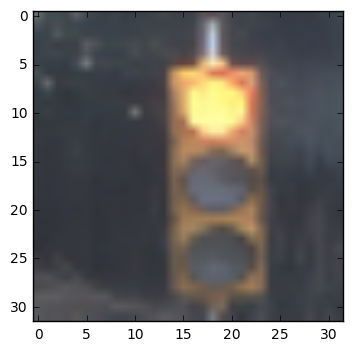

Predicted traffic light by tensorflow graph: red


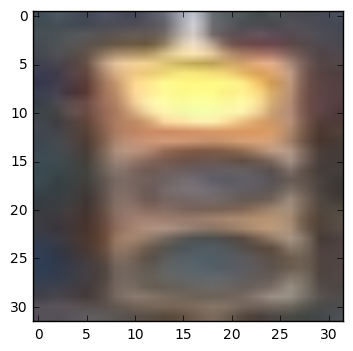

Predicted traffic light by tensorflow graph: red


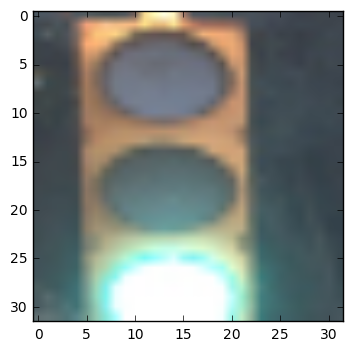

Predicted traffic light by tensorflow graph: green


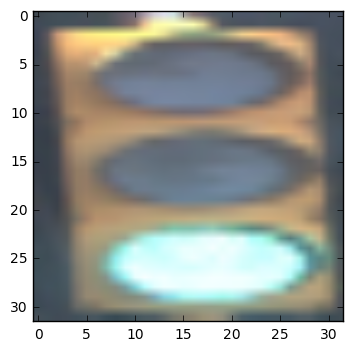

Predicted traffic light by tensorflow graph: green


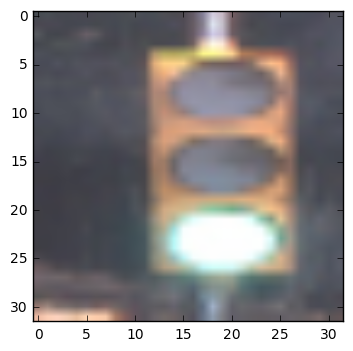

Predicted traffic light by tensorflow graph: green


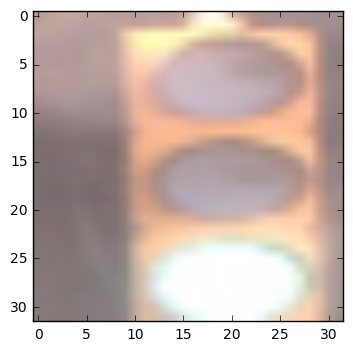

Predicted traffic light by tensorflow graph: green


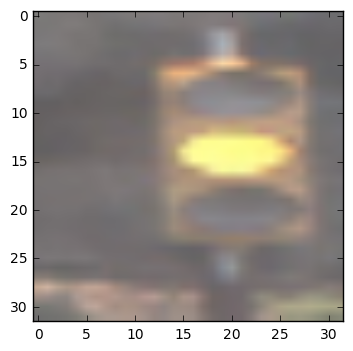

Predicted traffic light by tensorflow graph: yellow


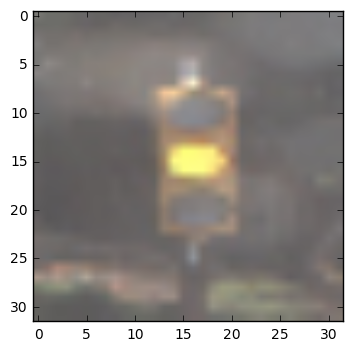

Predicted traffic light by tensorflow graph: yellow


In [ ]:
for img in test_set:
    with tf.Session(graph=graph, config=config) as sess:   
        plt.imshow(img)
        plt.show()
        pred_ = list(sess.run(tf.nn.softmax(out_graph.eval(feed_dict={in_graph: [img]}))))
        pred_idx = pred_.index(max(pred_))
        predicted_label = image_types[pred_idx]
        print("Predicted traffic light by tensorflow graph: {}".format(predicted_label))